In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

#import seaborn as sns
#sns.set()
# Thiner line width
# globally
#from matplotlib import rcParams
#rcParams['patch.linewidth'] = 0.0 #0.5

TensorFlow 2.x selected.


In [2]:
import sys
print(sys.version_info)
print(sys.version) 
print("tensorflow: ",tf.__version__)
tf.random.set_seed(13)

sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
tensorflow:  2.1.0-rc1


In [0]:
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = '/content/drive/My Drive/Colab Notebooks/schedule_dataset.xlsx'
else:
    data_path = 'schedule_dataset.xlsx'    

In [5]:
df = pd.read_excel(data_path)
df.columns

Index(['Дата рейса', 'Рейс', 'А/П отправл', 'А/П прибыт', 'Номер ВС',
       'Время отправления по расписанию', 'Время отправления фактическое',
       'Время прибытия по расписанию', 'Время прибытия фактическое'],
      dtype='object')

In [7]:
df.head()

,Дата рейса,Рейс,А/П отправл,А/П прибыт,Номер ВС,Время отправления по расписанию,Время отправления фактическое,Время прибытия по расписанию,Время прибытия фактическое
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


In [8]:
new_col_names=['date','flight','dep','dst','plane_id','dep_time_sched','dep_time_fact',
               'dst_time_sched','dst_time_fact']
df.columns = new_col_names
df.head()

,date,flight,dep,dst,plane_id,dep_time_sched,dep_time_fact,dst_time_sched,dst_time_fact
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00


In [9]:
delta_min = pd.Timedelta(minutes=1) 
delta_min

Timedelta('0 days 00:01:00')

# Feature engineering

In [0]:
def add_features(df):
    """ Add calculated features: 
        - Flight duration (minutes)
        - Difference between factual and scheduled depature times (minutes)
        - Difference between factual and scheduled destination arrival times (minutes)
    """
    df = df.assign(
        duration = df.apply(lambda row: (row['dst_time_sched'] - row['dep_time_sched']) / delta_min, axis=1))

    df = df.assign(
        dep_diff = df.apply(lambda row: (row['dep_time_fact'] - row['dep_time_sched']) / delta_min, axis=1))

    df = df.assign(
        dst_diff = df.apply(lambda row: (row['dst_time_fact'] - row['dst_time_sched']) / delta_min, axis=1))
            
    return df

In [0]:
df = add_features(df)


In [12]:
# Add column with counts of flights per day
df['dep_cnt'] = df.groupby(['date','dep'])['date'].transform('size')
df.head()

,date,flight,dep,dst,plane_id,dep_time_sched,dep_time_fact,dst_time_sched,dst_time_fact,duration,dep_diff,dst_diff,dep_cnt
0,2018-03-01,1,MOW,ARH,1,2018-03-01 00:05:00,2018-02-28 23:48:00,2018-03-01 02:00:00,2018-03-01 01:48:00,115.0,-17.0,-12.0,329
1,2018-03-01,2,MOW,EGO,2,2018-03-01 00:05:00,2018-03-01 00:00:00,2018-03-01 01:30:00,2018-03-01 01:55:00,85.0,-5.0,25.0,329
2,2018-03-01,3,MOW,AKX,3,2018-03-01 00:15:00,2018-03-01 00:14:00,2018-03-01 02:40:00,2018-03-01 02:32:00,145.0,-1.0,-8.0,329
3,2018-03-01,4,LED,MOW,4,2018-03-01 00:20:00,2018-03-01 00:11:00,2018-03-01 01:35:00,2018-03-01 01:39:00,75.0,-9.0,4.0,20
4,2018-03-01,5,MOW,KRR,5,2018-03-01 00:25:00,2018-03-01 00:21:00,2018-03-01 02:40:00,2018-03-01 02:41:00,135.0,-4.0,1.0,329


In [0]:
def plot_hist(data, xlabel, bins=None):
    """ Plot histagram
    """
    if not bins:
        bins = int(np.sqrt(len(data)))
    #_= plt.figure(figsize=(6,8))
    _= plt.xlabel(xlabel)
    _= plt.hist(data, bins=bins)

In [0]:
# Add month, day, week day, hour and minute of depature and arrival as separate features
df['dep_month'], df['dep_day'], df['dep_weekday'], df['dep_hour'], df['dep_ minute'] =  (df['dep_time_sched'].dt.month, 
                                                                          df['dep_time_sched'].dt.day, 
                                                                          df['dep_time_sched'].dt.weekday,
                                                                          df['dep_time_sched'].dt.hour, 
                                                                          df['dep_time_sched'].dt.minute)

In [15]:
uni_data = df['dep_diff']
uni_data.index = df['dep_time_sched']
uni_data.head()

dep_time_sched
2018-03-01 00:05:00   -17.0
2018-03-01 00:05:00    -5.0
2018-03-01 00:15:00    -1.0
2018-03-01 00:20:00    -9.0
2018-03-01 00:25:00    -4.0
Name: dep_diff, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9dddf28d0>],
      dtype=object)

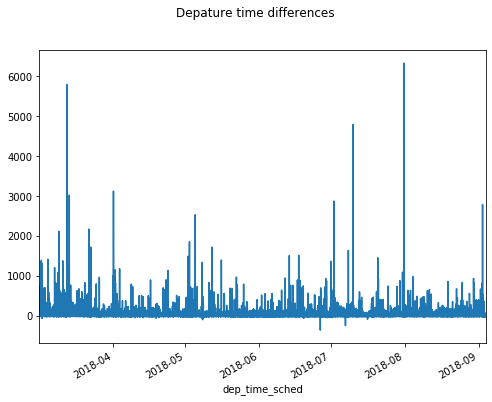

In [16]:
uni_data.plot(subplots=True, title='Depature time differences')

In [17]:
TRAIN_SPLIT = int(len(df) * 0.7)
len(df), TRAIN_SPLIT

(139732, 97812)

# LSTM:  Forecast a multivariate time series

In [0]:
# Prepare data for LSTM: shuffle, batch, and cache the dataset.
BATCH_SIZE = 256
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 10


# Single step model

In [19]:
df.columns

Index(['date', 'flight', 'dep', 'dst', 'plane_id', 'dep_time_sched',
       'dep_time_fact', 'dst_time_sched', 'dst_time_fact', 'duration',
       'dep_diff', 'dst_diff', 'dep_cnt', 'dep_month', 'dep_day',
       'dep_weekday', 'dep_hour', 'dep_ minute'],
      dtype='object')

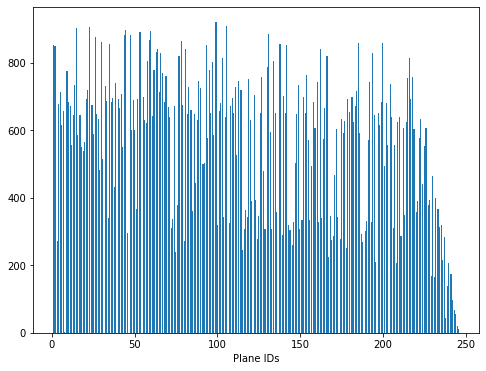

In [20]:
plot_hist(df['plane_id'], xlabel='Plane IDs')

In [21]:
predictors = ['plane_id', 'dep_diff', 'dep_cnt']
features = df[predictors]
features.index = df['dep_time_sched']
features.head()

,plane_id,dep_diff,dep_cnt
dep_time_sched,,,
2018-03-01 00:05:00,1,-17.0,329
2018-03-01 00:05:00,2,-5.0,329
2018-03-01 00:15:00,3,-1.0,329
2018-03-01 00:20:00,4,-9.0,20
2018-03-01 00:25:00,5,-4.0,329


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff9e424d860>,
      dtype=object)

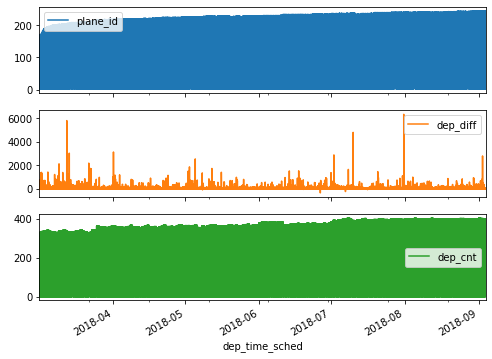

In [22]:
features.plot(subplots=True)

In [0]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [26]:
x_train_single.shape

(97092, 120, 3)

In [27]:
print ('Single window of past history :', x_train_single[0].shape)

Single window of past history : (120, 3)


In [0]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [33]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [34]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 26s 130ms/step - loss: 0.2081 - val_loss: 0.1658
Epoch 2/10
200/200 [==============================] - 24s 122ms/step - loss: 0.1810 - val_loss: 0.1651
Epoch 3/10
200/200 [==============================] - 24s 121ms/step - loss: 0.1912 - val_loss: 0.1634
Epoch 4/10
200/200 [==============================] - 24s 121ms/step - loss: 0.1953 - val_loss: 0.1637
Epoch 5/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1801 - val_loss: 0.1639
Epoch 6/10
200/200 [==============================] - 24s 118ms/step - loss: 0.1978 - val_loss: 0.1634
Epoch 7/10
200/200 [==============================] - 24s 120ms/step - loss: 0.1757 - val_loss: 0.1647
Epoch 8/10
200/200 [==============================] - 24s 118ms/step - loss: 0.1970 - val_loss: 0.1646
Epoch 9/10
200/200 [==============================] - 24s 119ms/step - loss: 0.1718 - val_loss: 0.1630
Epoch 10/10
200/200 [=========

In [0]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

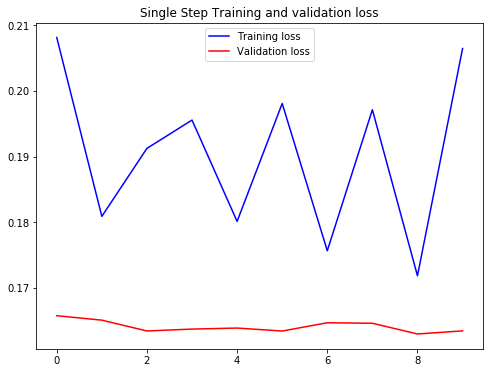

In [36]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

In [0]:
def create_time_steps(length):
    return list(range(-length, 0))

In [0]:
def show_plot(plot_data, delta, title):
    """Plot history annd next value to predict
    """
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['*-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

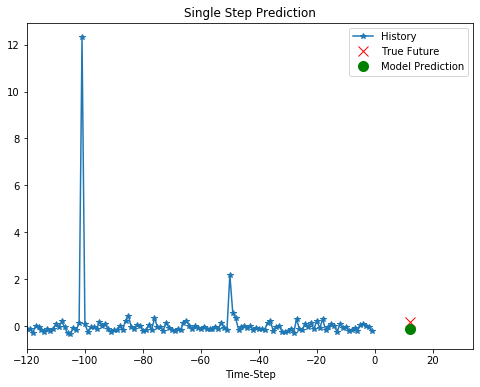

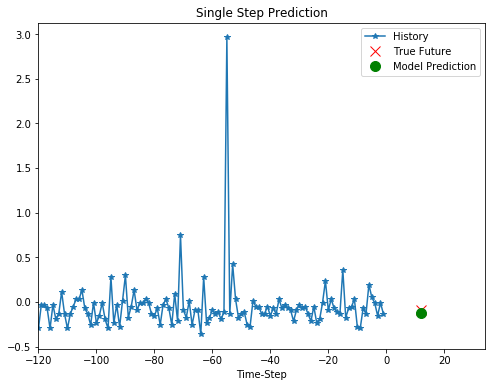

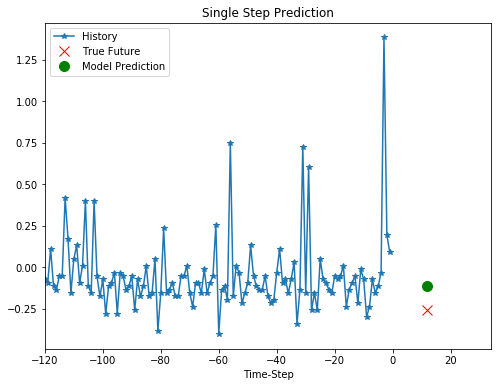

In [44]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

# Multi-Step model
Given a past history, the model learns to predict a sequence of depature time differences. 

Training data consists of recordings over the past, the output is a sequence of predictions. 

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [46]:
print ('Single window of past history : ', x_train_multi[0].shape)
print ('\n Target depature time difference to predict : ', y_train_multi[0].shape)

Single window of past history :  (120, 3)

 Target depature time difference to predict :  (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b.',
             label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r.',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

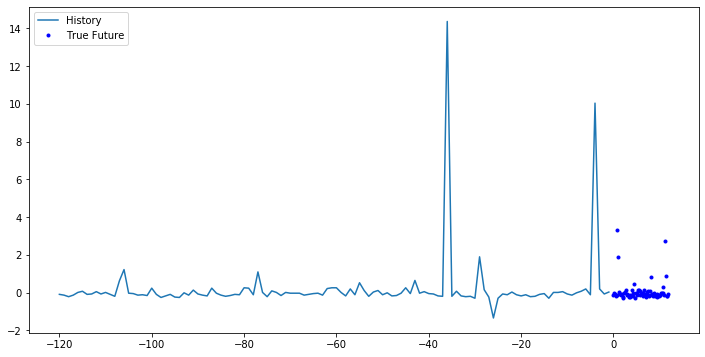

In [49]:
# Plot values to be predicted
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
# Model with two LSTM layers
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [51]:
# See how model predicts before it is trained
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [52]:
# Train model
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 44s 222ms/step - loss: 0.2067 - val_loss: 0.1640
Epoch 2/10
200/200 [==============================] - 42s 209ms/step - loss: 0.1801 - val_loss: 0.1637
Epoch 3/10
200/200 [==============================] - 42s 210ms/step - loss: 0.1937 - val_loss: 0.1639
Epoch 4/10
200/200 [==============================] - 42s 208ms/step - loss: 0.1880 - val_loss: 0.1634
Epoch 5/10
200/200 [==============================] - 42s 210ms/step - loss: 0.1834 - val_loss: 0.1634
Epoch 6/10
200/200 [==============================] - 42s 209ms/step - loss: 0.1954 - val_loss: 0.1633
Epoch 7/10
200/200 [==============================] - 42s 208ms/step - loss: 0.1758 - val_loss: 0.1628
Epoch 8/10
200/200 [==============================] - 43s 214ms/step - loss: 0.2000 - val_loss: 0.1630
Epoch 9/10
200/200 [==============================] - 42s 210ms/step - loss: 0.1720 - val_loss: 0.1627
Epoch 10/10
200/200 [=========

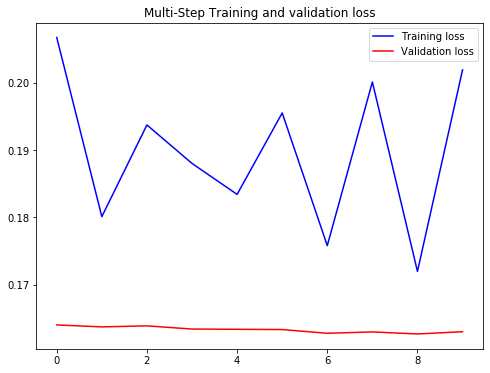

In [53]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

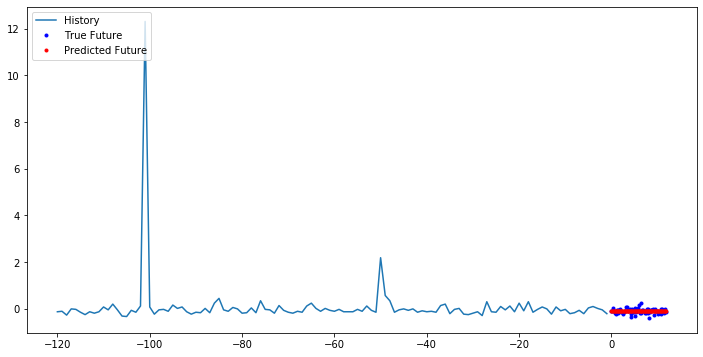

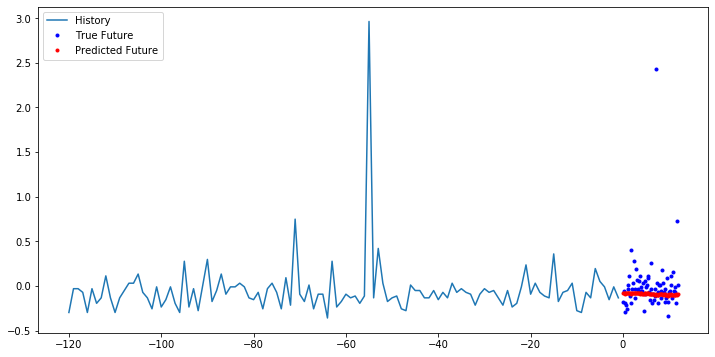

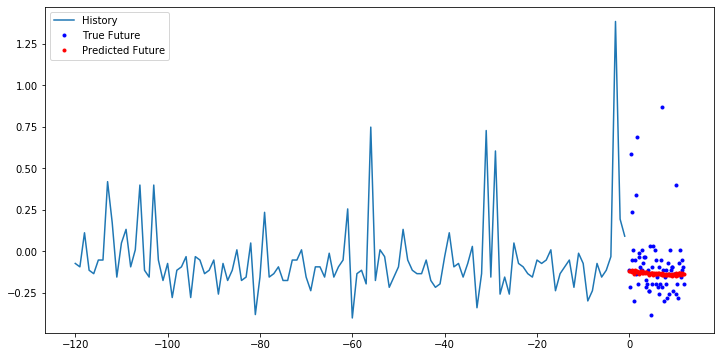

In [54]:
# Predict future departure time differences
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])